# Missingness Analysis for CRRT Cohort

This notebook analyzes the characteristics of encounters dropped due to missing labs compared to those retained in the final analysis.

## Objectives:
1. Compare demographics between dropped and retained encounters
2. Compare mortality outcomes (30-day, 90-day, in-hospital)
3. Compare CRRT parameters and clinical characteristics
4. Assess potential selection bias introduced by lab requirements

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import warnings
import json
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load configuration
config_path = "../config/config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

## import outlier json
# with open('../config/outlier_config.json', 'r', encoding='utf-8') as f:
#     outlier_cfg = json.load(f)

print(f"\n=� Configuration:")
print(f"   Data directory: {config['tables_path']}")
print(f"   File type: {config['file_type']}")
print(f"   Timezone: {config['timezone']}")


=� Configuration:
   Data directory: /Users/kavenchhikara/Projects/CLIF/CLIF-MIMIC/output/rclif-dev-test
   File type: parquet
   Timezone: US/Eastern


# 1. Load Dropped Encounters

In [3]:
# Load dropped encounters
dropped_encounters = pd.read_parquet('../output/intermediate/dropped_missing_labs_blocks.parquet')
print(f"  Loaded {len(dropped_encounters):,} encounters")

  Loaded 534 encounters


In [4]:
adult_hosp_ids = dropped_encounters['hospitalization_id'].unique().tolist()
adult_encounter_blocks= dropped_encounters['encounter_block'].unique().tolist()
print(f"Extracted {len(adult_hosp_ids):,} unique adult hospitalization IDs from dropped encounters.")

Extracted 534 unique adult hospitalization IDs from dropped encounters.


In [5]:
# ============================================================================
# STEP 0: Load Core Tables (Patient, Hospitalization, ADT)
# ============================================================================

print("\n" + "=" * 80)
print("Loading CLIF Tables")
print("=" * 80)

from clifpy.clif_orchestrator import ClifOrchestrator

# Initialize ClifOrchestrator
clif = ClifOrchestrator(
    data_directory=config['tables_path'],
    filetype=config['file_type'],
    timezone=config['timezone']
)

print("\n" + "=" * 80)
print("Step 0: Load Core Tables (Patient, Hospitalization, ADT)")
print("=" * 80)
core_tables = ['patient', 'hospitalization', 'adt']

print(f"\nLoading {len(core_tables)} core tables...")
for table_name in core_tables:
    print(f"   Loading {table_name}...", end=" ")
    try:
        clif.load_table(table_name, )
        table = getattr(clif, table_name)
        print(f"✓ ({len(table.df):,} rows)")
    except Exception as e:
        print(f"✗ Error: {e}")
        raise

print("\nCore tables loaded successfully!")


Loading CLIF Tables
ClifOrchestrator initialized.

Step 0: Load Core Tables (Patient, Hospitalization, ADT)

Loading 3 core tables...
   Loading patient... ✓ (364,627 rows)
   Loading hospitalization... ✓ (546,028 rows)
   Loading adt... ✓ (1,458,408 rows)

Core tables loaded successfully!


In [6]:
# Filter adt table to only those hospitalization_ids in adult_hosp_ids
adt_final_stitched = clif.adt.df[clif.adt.df['hospitalization_id'].isin(adult_hosp_ids)].copy()

# Merge in encounter_block from dropped_encounters (using hospitalization_id and encounter_block keys)
adt_final_stitched = adt_final_stitched.merge(
    dropped_encounters[['hospitalization_id', 'encounter_block']].drop_duplicates(),
    on='hospitalization_id',
    how='left'
)

In [7]:
cohort_df = clif.hospitalization.df[
    clif.hospitalization.df["hospitalization_id"].isin(adult_hosp_ids)].copy()

cohort_df = cohort_df.merge(
    clif.patient.df, 
    on="patient_id", 
    how="left"
)

cohort_df = cohort_df.merge(
    dropped_encounters,
    on='hospitalization_id',
    how='left'
)

In [8]:
print(f"\nLoading vitals table...")
clif.load_table(
    'vitals',
    filters={
        'hospitalization_id': list(adult_hosp_ids)
    }
)
print(f"   Vitals loaded: {len(clif.vitals.df):,} rows")
print(f"   Unique vitals categories: {clif.vitals.df['vital_category'].nunique()}")
print(f"   Unique vitals hospitalizations: {clif.vitals.df['hospitalization_id'].nunique()}")

vitals_df = clif.vitals.df.merge(
    dropped_encounters[['hospitalization_id', 'encounter_block']].drop_duplicates(),
    on='hospitalization_id',
    how='left'
)

vitals_range = vitals_df.groupby('encounter_block').agg({
    'recorded_dttm': ['min', 'max']
}).reset_index()
vitals_range.columns = ['encounter_block', 'first_vital_dttm', 'last_vital_dttm']

# Join vitals_range with cohort_df on encounter_block
cohort_df = cohort_df.merge(
    vitals_range,
    on='encounter_block',
    how='left'
)


Loading vitals table...
   Vitals loaded: 1,666,374 rows
   Unique vitals categories: 9
   Unique vitals hospitalizations: 534


In [9]:
cohort_df.columns

Index(['patient_id', 'hospitalization_id', 'hospitalization_joined_id',
       'admission_dttm', 'discharge_dttm', 'age_at_admission',
       'admission_type_name', 'admission_type_category', 'discharge_name',
       'discharge_category', 'zipcode_nine_digit', 'zipcode_five_digit',
       'census_block_code', 'census_block_group_code', 'census_tract',
       'state_code', 'county_code', 'race_name', 'race_category',
       'ethnicity_name', 'ethnicity_category', 'sex_name', 'sex_category',
       'birth_date', 'death_dttm', 'language_name', 'language_category',
       'encounter_block', 'first_vital_dttm', 'last_vital_dttm'],
      dtype='object')

# 2. Outcomes

In [10]:
# ============================================================================
# OUTCOMES CALCULATION 
# ============================================================================

# 1. ICU LENGTH OF STAY 
print("\n1. Processing ICU segments...")
icu_segs = adt_final_stitched.copy()
icu_segs = icu_segs[
    (icu_segs['location_category'] == 'icu') &
    (icu_segs['in_dttm'].notna()) &
    (icu_segs['out_dttm'].notna()) &
    (icu_segs['out_dttm'] > icu_segs['in_dttm'])
]

print(f"   ICU segments identified: {len(icu_segs):,}")

# Calculate ICU LOS as sum of all ICU segment durations
icu_los = icu_segs[icu_segs['encounter_block'].isin(cohort_df['encounter_block'])].copy()
icu_los['seg_days'] = (icu_los['out_dttm'] - icu_los['in_dttm']).dt.total_seconds() / (24 * 3600)

icu_los_summary = icu_los.groupby('encounter_block').agg({
    'seg_days': 'sum'
}).reset_index()
icu_los_summary.rename(columns={'seg_days': 'icu_los_days'}, inplace=True)

print(f"   Median ICU LOS: {icu_los_summary['icu_los_days'].median():.2f} days")

# ============================================================================
# 2. HOSPITAL LENGTH OF STAY (difference between first and last vital)
# ============================================================================
print("\n3. Calculating Hospital Length of Stay...")
hosp_los = cohort_df[['encounter_block']].merge(
    vitals_range,
    on='encounter_block',
    how='left'
)

# Hospital LOS = last_vital_dttm - first_vital_dttm
hosp_los['hosp_los_days'] = (
    hosp_los['last_vital_dttm'] - hosp_los['first_vital_dttm']
).dt.total_seconds() / (24 * 3600)

# Ensure non-negative values
hosp_los['hosp_los_days'] = hosp_los['hosp_los_days'].apply(
    lambda x: max(x, 0) if pd.notna(x) and np.isfinite(x) else np.nan
)

print(f"   Median Hospital LOS: {hosp_los['hosp_los_days'].median():.2f} days")

# ============================================================================
# 4. DEATH STATUS AND FINAL OUTCOME DATETIME
# ============================================================================
print("\n4. Determining death status and final outcome datetime...")

# Get discharge category and death_dttm from hospitalization and patient tables
death_info = cohort_df.copy()

# Drop 'hospitalization_id' from death_info
if 'hospitalization_id' in death_info.columns:
    death_info = death_info.drop(columns=['hospitalization_id'])

# Collapse to unique encounter_block, aggregating required columns
death_info = death_info.sort_values('encounter_block')  

agg_dict = {
    'admission_type_category': 'last',
    'discharge_category': 'last',
    'race_category': 'last',
    'sex_category': 'last',
    'ethnicity_category': 'last',
    'death_dttm': 'last',
    'first_vital_dttm': 'min',
    'last_vital_dttm': 'max'
}

# Include all other columns not being aggregated with "first" to keep at least one value per group, unless they are non-aggregatable
for col in death_info.columns:
    if col not in agg_dict and col not in ['encounter_block']:
        agg_dict[col] = 'first'

death_info = death_info.groupby('encounter_block', as_index=False).agg(agg_dict)

# Standardize discharge category
death_info['discharge_category'] = death_info['discharge_category'].str.lower()

# Step 1: Determine if patient died (based on discharge_category)
death_info['died'] = death_info['discharge_category'].isin(['expired', 'hospice']).astype(int)

# Step 2: Determine final_outcome_dttm
# If died: use death_dttm if available, otherwise use last_vital_dttm
# If not died: use last_vital_dttm
death_info['final_outcome_dttm'] = (
    death_info['death_dttm']
    .fillna(death_info['last_vital_dttm'])  # Fallback to last_vital
    .where(death_info['died'] == 1, pd.NaT)  # Only keep for died==1, else NaT
)

print(f"   Patients identified as died (expired/hospice): {death_info['died'].sum():,}")

num_with_death_dttm = ((death_info['died'] == 1) & (death_info['death_dttm'].notna())).sum()
num_using_last_vital = ((death_info['died'] == 1) & (death_info['death_dttm'].isna())).sum()

print(f"   - With death_dttm: {num_with_death_dttm:,}")
print(f"   - Using last_vital_dttm: {num_using_last_vital:,}")

# ============================================================================
# 5. MORTALITY CALCULATIONS
# ============================================================================
print("\n5. Calculating mortality outcomes...")

# In-hospital death: died AND final_outcome_dttm is between first and last vital
death_info['in_hosp_death'] = (
    (death_info['died'] == 1) &
    (death_info['final_outcome_dttm'].notna()) &
    (death_info['final_outcome_dttm'] >= death_info['first_vital_dttm']) &
    (death_info['final_outcome_dttm'] <= death_info['last_vital_dttm'])
).astype(int)

# 30-day mortality: died AND final_outcome_dttm within 30 days of first vital
death_info['death_30d'] = (
    (death_info['died'] == 1) &
    (death_info['final_outcome_dttm'].notna()) &
    (death_info['final_outcome_dttm'] <= (death_info['first_vital_dttm'] + pd.Timedelta(days=30)))
).astype(int)


print(f"   In-hospital deaths: {death_info['in_hosp_death'].sum():,} ({death_info['in_hosp_death'].mean()*100:.1f}%)")
print(f"   30-day deaths: {death_info['death_30d'].sum():,} ({death_info['death_30d'].mean()*100:.1f}%)")

# ============================================================================
# 6. COMBINE ALL OUTCOMES
# ============================================================================
print("\n6. Combining all outcomes...")
outcomes_df = cohort_df[['hospitalization_id', 'encounter_block']].merge(
    icu_los_summary, on='encounter_block', how='left'
).merge(
    hosp_los[['encounter_block', 'hosp_los_days']], on='encounter_block', how='left'
).merge(
    death_info, on='encounter_block', how='left'
)

print(f"\nFinal outcomes dataset:")
print(f"   Total records: {len(outcomes_df):,}")
print(f"   Records with ICU LOS: {outcomes_df['icu_los_days'].notna().sum():,}")
print(f"   Records with Hospital LOS: {outcomes_df['hosp_los_days'].notna().sum():,}")
print(f"   In-hospital mortality rate: {outcomes_df['in_hosp_death'].mean()*100:.1f}%")
print(f"   30-day mortality rate: {outcomes_df['death_30d'].mean()*100:.1f}%")

# Display summary statistics
print("\n" + "="*60)
print("OUTCOMES SUMMARY STATISTICS")
print("="*60)
print(f"ICU LOS (days):")
print(f"  Median [IQR]: {outcomes_df['icu_los_days'].median():.1f} [{outcomes_df['icu_los_days'].quantile(0.25):.1f}-{outcomes_df['icu_los_days'].quantile(0.75):.1f}]")
print(f"\nHospital LOS (days):")
print(f"  Median [IQR]: {outcomes_df['hosp_los_days'].median():.1f} [{outcomes_df['hosp_los_days'].quantile(0.25):.1f}-{outcomes_df['hosp_los_days'].quantile(0.75):.1f}]")
print(f"\nMortality:")
print(f"  In-hospital: {outcomes_df['in_hosp_death'].sum():,}/{len(outcomes_df):,} ({outcomes_df['in_hosp_death'].mean()*100:.1f}%)")
print(f"  30-day: {outcomes_df['death_30d'].sum():,}/{len(outcomes_df):,} ({outcomes_df['death_30d'].mean()*100:.1f}%)")
print("="*60)

# Convert specified columns to lowercase (if they exist)
category_cols = [
    'admission_type_category', 'discharge_category',
    'race_category', 'sex_category', 'ethnicity_category'
]
for col in category_cols:
    if col in outcomes_df.columns:
        outcomes_df[col] = outcomes_df[col].str.lower()

# Arrange columns: patient_id, hospitalization_id, encounter_block, then everything else
front_cols = [col for col in ['patient_id', 'hospitalization_id', 'encounter_block'] if col in outcomes_df.columns]
other_cols = [col for col in outcomes_df.columns if col not in front_cols]
outcomes_df = outcomes_df[front_cols + other_cols]


1. Processing ICU segments...
   ICU segments identified: 1,121
   Median ICU LOS: 13.07 days

3. Calculating Hospital Length of Stay...
   Median Hospital LOS: 15.65 days

4. Determining death status and final outcome datetime...
   Patients identified as died (expired/hospice): 263
   - With death_dttm: 240
   - Using last_vital_dttm: 23

5. Calculating mortality outcomes...
   In-hospital deaths: 77 (14.4%)
   30-day deaths: 213 (39.9%)

6. Combining all outcomes...

Final outcomes dataset:
   Total records: 534
   Records with ICU LOS: 526
   Records with Hospital LOS: 534
   In-hospital mortality rate: 14.4%
   30-day mortality rate: 39.9%

OUTCOMES SUMMARY STATISTICS
ICU LOS (days):
  Median [IQR]: 13.1 [7.1-23.7]

Hospital LOS (days):
  Median [IQR]: 15.7 [7.5-26.3]

Mortality:
  In-hospital: 77/534 (14.4%)
  30-day: 213/534 (39.9%)


# 3. CRRT Dose

In [11]:
print(f"\nLoading crrt_therapy table...")
try:
    clif.load_table(
        'crrt_therapy',
        filters={'hospitalization_id': list(adult_hosp_ids)}
    )
    print(f"   CRRT therapy loaded: {len(clif.crrt_therapy.df):,} rows")
    print(f"   Unique CRRT therapy hospitalizations: {clif.crrt_therapy.df['hospitalization_id'].nunique()}")
except Exception as e:
    print(f"   CRRT therapy not available or error: {e}")

crrt_df = clif.crrt_therapy.df
# Join dropped encounters (those not present in crrt_df) with crrt_df on hospitalization_id
# Now join these dropped encounters with crrt_df on hospitalization_id
crrt_df = crrt_df.merge(
    dropped_encounters, on='hospitalization_id', how='left', indicator=True
)
print(f"   Dropped encounters joined: {len(crrt_df):,}")


Loading crrt_therapy table...
   CRRT therapy loaded: 84,638 rows
   Unique CRRT therapy hospitalizations: 534
   Dropped encounters joined: 84,638


In [12]:
print("\n" + "=" * 80)
print("Processing CRRT Data")
print("=" * 80)
print(f"   CRRT therapy loaded: {len(clif.crrt_therapy.df):,} rows")
print(f"   Unique CRRT therapy hospitalizations: {clif.crrt_therapy.df['hospitalization_id'].nunique()}")
# ============================================================================
#  Define CRRT Initiation Time
# ============================================================================
print("\n1. Defining CRRT initiation time...")

# Filter crrt_df to only include hospitalization_ids present in the cohort
crrt_cohort = crrt_df[crrt_df['hospitalization_id'].isin(cohort_df['hospitalization_id'])].copy()

# Sort by encounter_block and time
crrt_cohort = crrt_cohort.sort_values(['encounter_block', 'recorded_dttm'])

# Create indicator for any CRRT activity (any non-null flow rate)
crrt_cohort['has_crrt_activity'] = (
    (
        crrt_cohort['dialysate_flow_rate'].notna() & (crrt_cohort['dialysate_flow_rate'] > 0)
    ) |
    (
        crrt_cohort['pre_filter_replacement_fluid_rate'].notna() & (crrt_cohort['pre_filter_replacement_fluid_rate'] > 0)
    ) |
    (
        crrt_cohort['post_filter_replacement_fluid_rate'].notna() & (crrt_cohort['post_filter_replacement_fluid_rate'] > 0)
    )
)

# Get CRRT initiation time (first non-null flow rate per encounter_block)
crrt_initiation = (crrt_cohort[crrt_cohort['has_crrt_activity']]
                    .groupby('encounter_block')
                    .agg({'recorded_dttm': 'min'})
                    .reset_index())
crrt_initiation.rename(columns={'recorded_dttm': 'crrt_initiation_time'}, inplace=True)

print(f"   CRRT initiation times identified for: {len(crrt_initiation):,} encounter_blocks")
print(f"   Date range: {crrt_initiation['crrt_initiation_time'].min()} to {crrt_initiation['crrt_initiation_time'].max()}")

# ============================================================================
# Get CRRT Parameters at Initiation
# ============================================================================
print("\n4. Getting CRRT parameters at initiation time...")
# Merge initiation times back to crrt_cohort
crrt_cohort = crrt_cohort.merge(crrt_initiation, on='encounter_block', how='left')
# Filter to records at exactly the initiation time
crrt_at_initiation = crrt_cohort[
    crrt_cohort['recorded_dttm'] == crrt_cohort['crrt_initiation_time']
].copy()

print(f"   CRRT records at initiation: {len(crrt_at_initiation):,}")
print(f"   Unique encounter blocks: {crrt_at_initiation['encounter_block'].nunique():,}")


Processing CRRT Data
   CRRT therapy loaded: 84,638 rows
   Unique CRRT therapy hospitalizations: 534

1. Defining CRRT initiation time...
   CRRT initiation times identified for: 534 encounter_blocks
   Date range: 2110-08-24 20:24:00-05:00 to 2209-07-26 18:45:00-05:00

4. Getting CRRT parameters at initiation time...
   CRRT records at initiation: 534
   Unique encounter blocks: 534


In [13]:
# Keep only rows where vital_category is 'weight_kg'
weight_df = clif.vitals.df[clif.vitals.df['vital_category'] == 'weight_kg'].copy()
weight_df = weight_df.merge(dropped_encounters[['hospitalization_id', 'encounter_block']], 
                            on='hospitalization_id', how='inner')

# clif.vitals.df = None ## clear from memory

# ============================================================================
#  Get Closest Weight to CRRT Initiation
# ============================================================================
print("\nFinding closest weights to CRRT initiation time...")
if 'vital_value' in weight_df.columns:
    weight_df = weight_df.rename(columns={'vital_value': 'weight_kg'})
if 'vital_category' in weight_df.columns:
    weight_df = weight_df.drop(columns=['vital_category'])
print(f"   Weight records available: {len(weight_df):,}")

combined = crrt_initiation.merge(weight_df, on='encounter_block', how='inner')

before_mask = combined['recorded_dttm'] <= combined['crrt_initiation_time']
combined_before = combined[before_mask].copy()
combined_before_sorted = combined_before.sort_values(['encounter_block', 'recorded_dttm'])
closest_before = (combined_before_sorted
                  .groupby('encounter_block')
                  .last()
                  .reset_index())

all_blocks = set(combined['encounter_block'])
blocks_with_before = set(closest_before['encounter_block'])
blocks_missing = all_blocks - blocks_with_before
print("Blocks without weight recorded before initiation time:", len(blocks_missing))

after_mask = (
    combined['encounter_block'].isin(blocks_missing) &
    (combined['recorded_dttm'] > combined['crrt_initiation_time']) &
    (combined['weight_kg'].notnull())
)
combined_after = combined[after_mask].copy()
combined_after_sorted = combined_after.sort_values(['encounter_block', 'recorded_dttm'])
first_after = (combined_after_sorted
               .groupby('encounter_block')
               .first()
               .reset_index())

num_taken_after = len(first_after)
print(f"   Number of weights from after initiation: {num_taken_after}")

combined_final = pd.concat([closest_before, first_after], axis=0, ignore_index=True)
combined = combined_final

closest_weights = (combined
                .sort_values(['encounter_block', 'recorded_dttm'])
                .groupby('encounter_block')
                .last()
                .reset_index())

closest_weights = closest_weights[['encounter_block', 'weight_kg']]

print(f"   Weights found for: {len(closest_weights):,} encounter_blocks")

# Calculate and print the number of encounter blocks for which weights were not found
all_encounter_blocks_with_crrt = set(crrt_initiation['encounter_block'].unique())
encounter_blocks_with_weights = set(closest_weights['encounter_block'].unique())
encounter_blocks_without_weights = all_encounter_blocks_with_crrt - encounter_blocks_with_weights
print(f"   Weights NOT found for: {len(encounter_blocks_without_weights):,} encounter_blocks")


Finding closest weights to CRRT initiation time...
   Weight records available: 35,651
Blocks without weight recorded before initiation time: 4
   Number of weights from after initiation: 4
   Weights found for: 534 encounter_blocks
   Weights NOT found for: 0 encounter_blocks


In [14]:

print("\n6. Combining CRRT data with weights...")

index_crrt_df = crrt_at_initiation.merge(
    closest_weights,
    on='encounter_block',
    how='inner'
)

print(f"   Final dataset: {len(index_crrt_df):,} records")
print(f"   Records with weights: {index_crrt_df['weight_kg'].notna().sum():,}")
print(f"   Records with CRRT mode: {index_crrt_df['crrt_mode_category'].notna().sum():,}")


6. Combining CRRT data with weights...
   Final dataset: 534 records
   Records with weights: 534
   Records with CRRT mode: 456


In [15]:
# crrt_cohort = crrt_cohort[crrt_cohort['encounter_block'].isin(dropped_encounters)]

# Define desired column order
desired_order = [
    'hospitalization_id', 'encounter_block', 'recorded_dttm', 
    'crrt_mode_category', 'dialysate_flow_rate', 'pre_filter_replacement_fluid_rate', 
    'post_filter_replacement_fluid_rate', 'ultrafiltration_out', 
    'blood_flow_rate', 'crrt_initiation_time'
]
# Only keep columns that exist in crrt_cohort
front_cols = [col for col in desired_order if col in crrt_cohort.columns]
other_cols = [col for col in crrt_cohort.columns if col not in front_cols]
crrt_cohort = crrt_cohort[front_cols + other_cols]

# Sort as specified
crrt_cohort = crrt_cohort.sort_values(['encounter_block', 'recorded_dttm'])
print("\n Calculating CRRT dose at initiation...")

# First, filter for valid CRRT modes only
valid_modes = ['cvvh', 'cvvhd', 'cvvhdf']
crrt_cohort['crrt_mode_category'] = crrt_cohort['crrt_mode_category'].str.lower()

print(f"   Total CRRT records before filtering: {len(crrt_df):,}")
crrt_df_filtered = crrt_cohort[crrt_cohort['crrt_mode_category'].isin(valid_modes)].copy()
print(f"   Records after filtering for valid modes (cvvh, cvvhd, cvvhdf): {len(crrt_df_filtered):,}")
print(f"   Excluded records: {len(crrt_df) - len(crrt_df_filtered):,}")

# Fill NaN values with 0 for flow rate columns
flow_cols = ['dialysate_flow_rate', 'pre_filter_replacement_fluid_rate',
            'post_filter_replacement_fluid_rate']

# Drop rows where all 3 variables are missing
crrt_df_filtered = crrt_df_filtered.dropna(subset=flow_cols, how='all')

# Then fill remaining NaNs in those columns with 0
crrt_df_filtered[flow_cols] = crrt_df_filtered[flow_cols].fillna(0)

print("\n   Mode distribution across all time points:")
print(crrt_df_filtered['crrt_mode_category'].value_counts())

# Calculate mode-specific dose at EACH time point
conditions = [
    crrt_df_filtered['crrt_mode_category'] == 'cvvhd',
    crrt_df_filtered['crrt_mode_category'] == 'cvvh',
    crrt_df_filtered['crrt_mode_category'] == 'cvvhdf'
]

choices = [
    crrt_df_filtered['dialysate_flow_rate'],
    crrt_df_filtered['pre_filter_replacement_fluid_rate'] + crrt_df_filtered['post_filter_replacement_fluid_rate'],
    crrt_df_filtered['dialysate_flow_rate'] + crrt_df_filtered['pre_filter_replacement_fluid_rate'] +
    crrt_df_filtered['post_filter_replacement_fluid_rate']
]

# Mode-specific total flow rate at each time point
crrt_df_filtered['total_flow_rate'] = np.select(conditions, choices, default=np.nan)

# Also calculate full flow rate (all components) at each time point
crrt_df_filtered['total_flow_rate_full'] = (
    crrt_df_filtered['dialysate_flow_rate'] +
    crrt_df_filtered['pre_filter_replacement_fluid_rate'] +
    crrt_df_filtered['post_filter_replacement_fluid_rate']
)

# Merge weight data (assuming weight_df has encounter_block and weight_kg)
crrt_df_filtered = crrt_df_filtered.merge(
    closest_weights[['encounter_block', 'weight_kg']].drop_duplicates(),
    on='encounter_block',
    how='left'
)

# Calculate dose at each time point
crrt_df_filtered['crrt_dose_ml_kg_hr'] = np.where(
    (crrt_df_filtered['weight_kg'] > 0) & (crrt_df_filtered['total_flow_rate'] > 0),
    crrt_df_filtered['total_flow_rate'] / crrt_df_filtered['weight_kg'],
    np.nan
)

crrt_df_filtered['crrt_dose_ml_kg_hr_full'] = np.where(
    (crrt_df_filtered['weight_kg'] > 0) & (crrt_df_filtered['total_flow_rate_full'] > 0),
    crrt_df_filtered['total_flow_rate_full'] / crrt_df_filtered['weight_kg'],
    np.nan
)

print(f"\n   Dose calculations at individual time points:")
print(f"     Mode-specific doses calculated: {crrt_df_filtered['crrt_dose_ml_kg_hr'].notna().sum():,}")
print(f"     Full doses calculated: {crrt_df_filtered['crrt_dose_ml_kg_hr_full'].notna().sum():,}")


 Calculating CRRT dose at initiation...
   Total CRRT records before filtering: 84,638
   Records after filtering for valid modes (cvvh, cvvhd, cvvhdf): 33,970
   Excluded records: 50,668

   Mode distribution across all time points:
crrt_mode_category
cvvhdf    31945
cvvhd      1117
cvvh        825
Name: count, dtype: int64

   Dose calculations at individual time points:
     Mode-specific doses calculated: 33,660
     Full doses calculated: 33,749


In [16]:
# ============================================================================
# Calculate Median Dose for First 3 Hours + Get Initiation Values
# ============================================================================

# Filter to first 3 hours after CRRT initiation
crrt_first_3hrs = crrt_df_filtered[
    crrt_df_filtered['recorded_dttm'] <= (crrt_df_filtered['crrt_initiation_time'] + pd.Timedelta(hours=3))
].copy()

print(f"   Records within first 3 hours: {len(crrt_first_3hrs):,}")

# Define columns to aggregate
dose_columns = ['dialysate_flow_rate', 'blood_flow_rate', 
                'pre_filter_replacement_fluid_rate', 
                'post_filter_replacement_fluid_rate', 'ultrafiltration_out',
                'total_flow_rate', 'total_flow_rate_full',
                'crrt_dose_ml_kg_hr', 'crrt_dose_ml_kg_hr_full']

# Calculate medians for first 3 hours
median_3hr = crrt_first_3hrs.groupby('encounter_block').agg({
    'hospitalization_id': 'first',
    'crrt_initiation_time': 'first',
    'weight_kg': 'first',
    'crrt_mode_category': lambda x: x.mode()[0] if not x.empty else np.nan,  # Most frequent mode
    **{col: 'median' for col in dose_columns}
}).reset_index()

print(f"   Encounters with median values calculated: {len(median_3hr):,}")

# Get values at initiation time (original values)
print("\n   Getting original values at initiation time...")

crrt_at_init = crrt_df_filtered[
    crrt_df_filtered['recorded_dttm'] == crrt_df_filtered['crrt_initiation_time']
].copy()

# Group by encounter_block and take first (should be unique at initiation time)
init_values = crrt_at_init.groupby('encounter_block').agg({
    col: 'first' for col in dose_columns
}).reset_index()

# Rename init columns to add _not_avged suffix
init_values = init_values.rename(columns={
    col: f'{col}_not_avged' for col in dose_columns
})

print(f"   Encounters with initiation values: {len(init_values):,}")

# Merge median and initiation values
final_df = median_3hr.merge(init_values, on='encounter_block', how='left')

# Now arrange columns in the requested order
# First the main columns (with median values)
main_columns = [
    'encounter_block', 'hospitalization_id', 'crrt_initiation_time',
    'weight_kg', 'crrt_mode_category',
    'dialysate_flow_rate', 'blood_flow_rate',
    'pre_filter_replacement_fluid_rate', 'post_filter_replacement_fluid_rate',
    'ultrafiltration_out', 'total_flow_rate', 'total_flow_rate_full',
    'crrt_dose_ml_kg_hr', 'crrt_dose_ml_kg_hr_full'
]

# Then the initiation columns (with _not_avged suffix)
not_avged_columns = [f'{col}_not_avged' for col in dose_columns]

# Combine all columns
all_columns = main_columns + not_avged_columns

# Select and reorder columns
final_df = final_df[all_columns]

print(f"\n   Final dataframe created:")
print(f"     Total rows: {len(final_df):,} (one per encounter)")
print(f"     Total columns: {len(final_df.columns)}")

# Assign to your desired variable name
index_crrt_df = final_df.copy()

print("\n✅ Final dataframe created with one row per encounter!")
print(f"   Stored as 'index_crrt_df' with {len(index_crrt_df)} encounters")

   Records within first 3 hours: 1,523
   Encounters with median values calculated: 494

   Getting original values at initiation time...
   Encounters with initiation values: 456

   Final dataframe created:
     Total rows: 494 (one per encounter)
     Total columns: 23

✅ Final dataframe created with one row per encounter!
   Stored as 'index_crrt_df' with 494 encounters



✓ Saved mode-specific comparison to: ../output/final/graphs/crrt_dose_comparison_by_mode.png


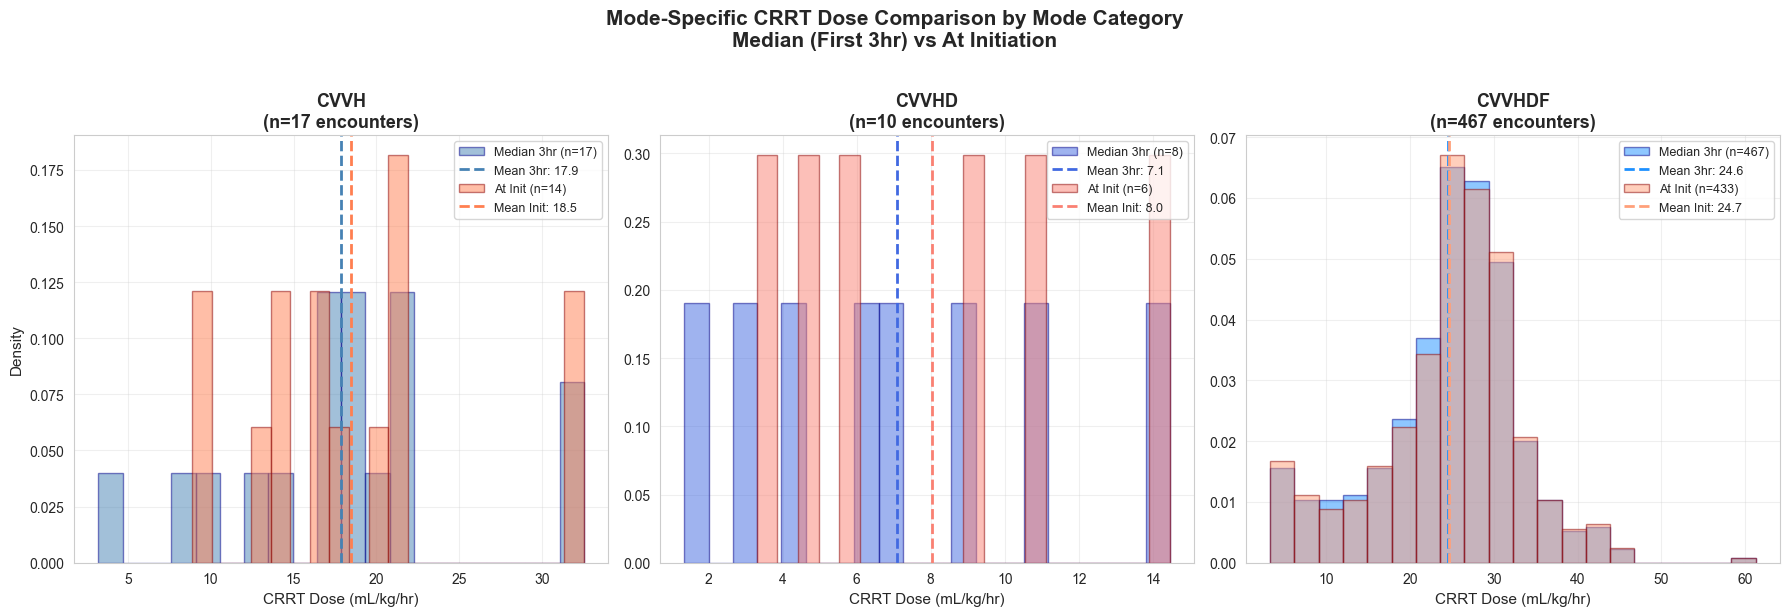

In [17]:
# ============================================================================
# Plot 2: Mode-Specific CRRT Dose Comparison by Mode Category
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique mode categories (excluding NaN)
mode_categories = final_df['crrt_mode_category'].dropna().unique()
mode_categories = sorted(mode_categories)  # Sort for consistent ordering

# Create figure with subplots for each mode
n_modes = len(mode_categories)
fig, axes = plt.subplots(1, n_modes, figsize=(6*n_modes, 6))

# If only one mode, make axes iterable
if n_modes == 1:
    axes = [axes]

# Color palette
colors_median = ['steelblue', 'royalblue', 'dodgerblue']
colors_init = ['coral', 'salmon', 'lightsalmon']

# Process each mode
for idx, mode in enumerate(mode_categories):
    ax = axes[idx]

    # Filter data for this mode
    mode_data = final_df[final_df['crrt_mode_category'] == mode]

    # Get dose values for this mode
    dose_median = mode_data['crrt_dose_ml_kg_hr'].dropna()
    dose_init = mode_data['crrt_dose_ml_kg_hr_not_avged'].dropna()

    # Skip if no data
    if len(dose_median) == 0 and len(dose_init) == 0:
        ax.text(0.5, 0.5, f'No data for {mode.upper()}',
                ha='center', va='center', fontsize=12)
        ax.set_title(f'{mode.upper()}', fontsize=14, fontweight='bold')
        continue

    # Create overlaid histograms
    if len(dose_median) > 0:
        ax.hist(dose_median, bins=20, alpha=0.5, label=f'Median 3hr (n={len(dose_median)})',
                color=colors_median[idx % len(colors_median)], edgecolor='darkblue', density=True)
        ax.axvline(dose_median.mean(), color=colors_median[idx % len(colors_median)],
                    linestyle='--', linewidth=2, label=f'Mean 3hr: {dose_median.mean():.1f}')

    if len(dose_init) > 0:
        ax.hist(dose_init, bins=20, alpha=0.5, label=f'At Init (n={len(dose_init)})',
                color=colors_init[idx % len(colors_init)], edgecolor='darkred', density=True)
        ax.axvline(dose_init.mean(), color=colors_init[idx % len(colors_init)],
                    linestyle='--', linewidth=2, label=f'Mean Init: {dose_init.mean():.1f}')

    # Labels and title
    ax.set_xlabel('CRRT Dose (mL/kg/hr)', fontsize=11)
    ax.set_ylabel('Density' if idx == 0 else '', fontsize=11)
    ax.set_title(f'{mode.upper()}\n(n={len(mode_data)} encounters)', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Overall title
fig.suptitle('Mode-Specific CRRT Dose Comparison by Mode Category\nMedian (First 3hr) vs At Initiation',
            fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()

# Save figure
output_path = '../output/final/graphs/crrt_dose_comparison_by_mode.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved mode-specific comparison to: {output_path}")
plt.show()


In [18]:
import pandas as pd
import numpy as np

def calculate_crrt_duration(crrt_cohort):
    """
    Calculate CRRT duration for each encounter.
    Duration is defined as the time from crrt_initiation_time to the last recorded setting,
    considering CRRT ended when there's a 24-hour gap in recordings.
    
    Parameters:
    -----------
    crrt_cohort : pd.DataFrame
        DataFrame with CRRT time series data including columns:
        - encounter_block: patient identifier
        - crrt_initiation_time: start of CRRT
        - recorded_dttm: timestamp column for each setting recording
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with encounter_block and calculated duration metrics
    """

    # Make a copy to avoid modifying original
    df = crrt_cohort.copy()

    # Ensure datetime columns are properly formatted
    time_column = 'recorded_dttm'
    df[time_column] = pd.to_datetime(df[time_column])
    df['crrt_initiation_time'] = pd.to_datetime(df['crrt_initiation_time'])

    # CRITICAL: Drop all rows where recorded_dttm is before crrt_initiation_time
    initial_rows = len(df)
    df = df[df[time_column] >= df['crrt_initiation_time']]
    rows_dropped = initial_rows - len(df)

    if rows_dropped > 0:
        print(f"Dropped {rows_dropped} recordings that occurred before CRRT initiation time")
        print(f"Remaining recordings: {len(df)}")

    # Sort by encounter and time
    df = df.sort_values(['encounter_block', time_column])

    # Function to calculate duration for each encounter
    def get_encounter_duration(group):
        """Calculate CRRT duration for a single encounter with 24-hour gap detection"""

        # Get initiation time
        initiation_time = group['crrt_initiation_time'].iloc[0]

        # Get all recorded times (already filtered to be >= initiation_time)
        recorded_times = group[time_column].dropna().sort_values()

        if len(recorded_times) == 0:
            # No recordings after initiation
            return pd.Series({
                'crrt_initiation_time': initiation_time,
                'crrt_end_time': initiation_time,
                'duration_hours': 0,
                'duration_days': 0,
                'num_recordings': 0,
                'had_24hr_gap': False
            })

        # Check for 24-hour gaps
        time_diffs = recorded_times.diff()

        # Find if there's any gap >= 24 hours
        gaps_24hr = time_diffs > pd.Timedelta(hours=24)

        if gaps_24hr.any():
            # CRRT ended at the last recording before the first 24-hour gap
            first_gap_idx = gaps_24hr.idxmax()
            # Get the index position of the gap
            gap_position = recorded_times.index.get_loc(first_gap_idx)
            # The end time is the recording just before the gap
            end_time = recorded_times.iloc[gap_position - 1]
            had_gap = True
        else:
            # No 24-hour gap, use the last recording
            end_time = recorded_times.iloc[-1]
            had_gap = False

        # Calculate duration
        duration = end_time - initiation_time
        duration_hours = duration.total_seconds() / 3600
        duration_days = duration_hours / 24

        # Count recordings
        num_recordings = len(recorded_times)

        return pd.Series({
            'crrt_initiation_time': initiation_time,
            'crrt_end_time': end_time,
            'duration_hours': duration_hours,
            'duration_days': duration_days,
            'num_recordings': num_recordings,
            'had_24hr_gap': had_gap
        })

    # Apply to each encounter
    duration_df = df.groupby('encounter_block').apply(get_encounter_duration).reset_index()

    # Add summary statistics
    print("\n=== CRRT Duration Summary ===")
    print(f"Total encounters: {len(duration_df)}")
    print(f"Encounters with recordings: {len(duration_df[duration_df['num_recordings'] > 0])}")
    print(f"Encounters without recordings: {len(duration_df[duration_df['num_recordings'] == 0])}")

    # Stats for encounters with recordings
    valid_durations = duration_df[duration_df['duration_hours'] > 0]

    if len(valid_durations) > 0:
        print(f"\nDuration Statistics (for {len(valid_durations)} encounters with valid recordings):")
        print(f"\nDuration (hours):")
        print(f"  Mean: {valid_durations['duration_hours'].mean():.1f}")
        print(f"  Median: {valid_durations['duration_hours'].median():.1f}")
        print(f"  Q25: {valid_durations['duration_hours'].quantile(0.25):.1f}")
        print(f"  Q75: {valid_durations['duration_hours'].quantile(0.75):.1f}")
        print(f"  Min: {valid_durations['duration_hours'].min():.1f}")
        print(f"  Max: {valid_durations['duration_hours'].max():.1f}")

        print(f"\nDuration (days):")
        print(f"  Mean: {valid_durations['duration_days'].mean():.1f}")
        print(f"  Median: {valid_durations['duration_days'].median():.1f}")
        print(f"  Q25: {valid_durations['duration_days'].quantile(0.25):.1f}")
        print(f"  Q75: {valid_durations['duration_days'].quantile(0.75):.1f}")

    print(f"\nEncounters with 24-hour gap: {duration_df['had_24hr_gap'].sum()} ({duration_df['had_24hr_gap'].mean()*100:.1f}%)")

    # Add duration categories
    duration_df['duration_category'] = pd.cut(
        duration_df['duration_days'],
        bins=[-0.001, 0, 1, 3, 7, 14, float('inf')],
        labels=['No duration', '<1 day', '1-3 days', '3-7 days', '7-14 days', '>14 days'],
        include_lowest=True
    )

    print(f"\nDuration categories:")
    print(duration_df['duration_category'].value_counts().sort_index())

    return duration_df

# Pre-processing function to check for pre-initiation recordings
def check_pre_initiation_recordings(crrt_cohort):
    """
    Check how many recordings occur before CRRT initiation time
    """
    df = crrt_cohort.copy()
    df['recorded_dttm'] = pd.to_datetime(df['recorded_dttm'])
    df['crrt_initiation_time'] = pd.to_datetime(df['crrt_initiation_time'])

    # Find pre-initiation recordings
    pre_init = df[df['recorded_dttm'] < df['crrt_initiation_time']]

    if len(pre_init) > 0:
        print("=== Pre-Initiation Recordings Found ===")
        print(f"Total pre-initiation recordings: {len(pre_init)} ({len(pre_init)/len(df)*100:.1f}% of all recordings)")
        print(f"Affected encounters: {pre_init['encounter_block'].nunique()}")

        # Calculate how early these recordings are
        pre_init['hours_before'] = (pre_init['crrt_initiation_time'] - pre_init['recorded_dttm']).dt.total_seconds() / 3600

        print(f"\nTiming statistics (hours before initiation):")
        print(f"  Mean: {pre_init['hours_before'].mean():.1f} hours")
        print(f"  Median: {pre_init['hours_before'].median():.1f} hours")
        print(f"  Max: {pre_init['hours_before'].max():.1f} hours")

        # Show a few examples
        print("\nExample pre-initiation recordings:")
        sample = pre_init.nlargest(5, 'hours_before')[['encounter_block', 'recorded_dttm', 'crrt_initiation_time', 'hours_before']]
        print(sample)
    else:
        print("No pre-initiation recordings found - data is clean!")

    return pre_init

# First check for pre-initiation recordings (optional)
pre_init_check = check_pre_initiation_recordings(crrt_cohort)

# Calculate duration (automatically drops pre-initiation recordings)
duration_df = calculate_crrt_duration(crrt_cohort)

# Merge back with main cohort
index_crrt_df = index_crrt_df.merge(
    duration_df[['encounter_block', 'duration_hours', 'duration_days', 'duration_category', 'had_24hr_gap']],
    on='encounter_block',
    how='left'
)

=== Pre-Initiation Recordings Found ===
Total pre-initiation recordings: 688 (0.8% of all recordings)
Affected encounters: 226

Timing statistics (hours before initiation):
  Mean: 72.8 hours
  Median: 52.5 hours
  Max: 1037.6 hours

Example pre-initiation recordings:
       encounter_block             recorded_dttm      crrt_initiation_time  \
14215            83567 2153-12-03 15:11:00-05:00 2154-01-15 20:46:00-05:00   
1821             15897 2160-10-26 12:30:00-05:00 2160-11-17 19:08:00-05:00   
74289           479370 2140-12-01 16:26:00-05:00 2140-12-11 21:15:00-05:00   
76933           502428 2182-04-11 18:15:00-05:00 2182-04-21 14:12:00-05:00   
76934           502428 2182-04-11 18:53:00-05:00 2182-04-21 14:12:00-05:00   

       hours_before  
14215   1037.583333  
1821     534.633333  
74289    244.816667  
76933    235.950000  
76934    235.316667  
Dropped 688 recordings that occurred before CRRT initiation time
Remaining recordings: 83950

=== CRRT Duration Summary ===
Total 

# 4. IMV duration

In [19]:
print(f"\nLoading respiratory support table...")
try:
    clif.load_table(
        'respiratory_support',
        filters={'hospitalization_id': adult_hosp_ids}
    )
    print(f"   respiratory_support loaded: {len(clif.respiratory_support.df):,} rows")
    print(f"   Unique respiratory_support hospitalizations: {clif.respiratory_support.df['hospitalization_id'].nunique()}")
except Exception as e:
    print(f"   CRRT therapy not available or error: {e}")


Loading respiratory support table...
   respiratory_support loaded: 72,532 rows
   Unique respiratory_support hospitalizations: 524


In [20]:
clif.respiratory_support.df = clif.respiratory_support.df.merge(
    dropped_encounters[['hospitalization_id', 'encounter_block']],
    on='hospitalization_id',
    how='left'
)
clif.respiratory_support = clif.respiratory_support.waterfall()
resp_support_df = clif.respiratory_support.df

Converting timezone from US/Eastern to UTC for waterfall processing
✦ Phase 0: initialise & create hourly scaffold
  • Building hourly scaffold via DuckDB
  • Scaffold rows created: 250,904
✦ Phase 1: heuristic inference of device & mode
3 rows had PEEP>0 on nasal cannula device_category reset
✦ Phase 2: build hierarchical IDs
✦ Phase 3: forward-only numeric fill inside mode_name_id blocks
  • applying waterfall fill to 524 encounters


Waterfall fill by mode_name_id: 100%|██████████| 8745/8745 [00:03<00:00, 2276.83it/s]


✦ Phase 4: final dedup & ordering
[OK] Respiratory-support waterfall complete.
Converting timezone from UTC back to US/Eastern after processing


In [21]:
def calculate_imv_duration(resp_support_df):
    """
    Calculate IMV duration for each encounter block.
    Duration is from first IMV recording to last IMV recording,
    considering IMV ended when there's a 24-hour gap without IMV.
    
    Parameters:
    -----------
    resp_support_df : pd.DataFrame
        DataFrame with columns: encounter_block, recorded_dttm, device_category
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with encounter_block and IMV duration metrics
    """

    # Make a copy to avoid modifying original
    df = resp_support_df.copy()

    # Convert recorded_dttm to datetime
    df['recorded_dttm'] = pd.to_datetime(df['recorded_dttm'])

    # Filter for IMV records only (case-insensitive)
    df['device_category_lower'] = df['device_category'].str.lower()
    imv_df = df[df['device_category_lower'] == 'imv'].copy()

    # Sort by encounter block and time
    imv_df = imv_df.sort_values(['encounter_block', 'recorded_dttm'])

    # Function to calculate duration for each encounter block
    def get_imv_duration(group):
        """Calculate IMV duration for a single encounter block"""

        # Get all IMV recording times
        recorded_times = group['recorded_dttm'].dropna().sort_values()

        if len(recorded_times) == 0:
            # No IMV recordings
            return pd.Series({
                'imv_start_time': pd.NaT,
                'imv_end_time': pd.NaT,
                'imv_duration_hours': 0,
                'imv_duration_days': 0
            })

        # IMV start time is the first recording
        imv_start_time = recorded_times.iloc[0]

        # Check for 24-hour gaps
        time_diffs = recorded_times.diff()

        # Find if there's any gap >= 24 hours
        gaps_24hr = time_diffs > pd.Timedelta(hours=24)

        if gaps_24hr.any():
            # IMV ended at the last recording before the first 24-hour gap
            first_gap_idx = gaps_24hr.idxmax()
            gap_position = recorded_times.index.get_loc(first_gap_idx)
            imv_end_time = recorded_times.iloc[gap_position - 1]
        else:
            # No 24-hour gap, use the last recording
            imv_end_time = recorded_times.iloc[-1]

        # Calculate duration
        duration = imv_end_time - imv_start_time
        duration_hours = duration.total_seconds() / 3600
        duration_days = duration_hours / 24

        return pd.Series({
            'imv_start_time': imv_start_time,
            'imv_end_time': imv_end_time,
            'imv_duration_hours': duration_hours,
            'imv_duration_days': duration_days
        })

    # Apply to each encounter block
    imv_duration_df = imv_df.groupby('encounter_block').apply(get_imv_duration).reset_index()

    return imv_duration_df

# Usage:
imv_duration_df = calculate_imv_duration(resp_support_df)
# Merge back with main cohort
index_crrt_df = index_crrt_df.merge(
    imv_duration_df[['encounter_block', 'imv_duration_hours', 'imv_duration_days']],
    on='encounter_block',
    how='left'
)

In [22]:
index_crrt_df.columns

Index(['encounter_block', 'hospitalization_id', 'crrt_initiation_time',
       'weight_kg', 'crrt_mode_category', 'dialysate_flow_rate',
       'blood_flow_rate', 'pre_filter_replacement_fluid_rate',
       'post_filter_replacement_fluid_rate', 'ultrafiltration_out',
       'total_flow_rate', 'total_flow_rate_full', 'crrt_dose_ml_kg_hr',
       'crrt_dose_ml_kg_hr_full', 'dialysate_flow_rate_not_avged',
       'blood_flow_rate_not_avged',
       'pre_filter_replacement_fluid_rate_not_avged',
       'post_filter_replacement_fluid_rate_not_avged',
       'ultrafiltration_out_not_avged', 'total_flow_rate_not_avged',
       'total_flow_rate_full_not_avged', 'crrt_dose_ml_kg_hr_not_avged',
       'crrt_dose_ml_kg_hr_full_not_avged', 'duration_hours', 'duration_days',
       'duration_category', 'had_24hr_gap', 'imv_duration_hours',
       'imv_duration_days'],
      dtype='object')

# 5. Missingness comparison

In [23]:
# ============================================================================
# MISSINGNESS COMPARISON: Table 1 - Dropped vs Retained Encounters
# ============================================================================

print("\n" + "=" * 80)
print("COMPARISON ANALYSIS: Dropped (Missing Labs) vs Retained Encounters")
print("=" * 80)

# ----------------------------------------------------------------------------
# 1. Load Full Cohort Data from Intermediate Files
# ----------------------------------------------------------------------------
print("\n1. Loading full cohort data from intermediate files...")

# Load the retained cohort data
full_outcomes_df = pd.read_parquet('../output/intermediate/outcomes_df.parquet')
full_index_crrt_df = pd.read_parquet('../output/intermediate/index_crrt_df.parquet')

print(f"   Full cohort outcomes: {len(full_outcomes_df):,} encounters")
print(f"   Full cohort CRRT data: {len(full_index_crrt_df):,} encounters")

# Get dropped encounter blocks
dropped_blocks = set(outcomes_df['encounter_block'].unique())
print(f"   Dropped encounters (missing labs): {len(dropped_blocks):,}")

# Rename local dfs to be clear they are the dropped group
dropped_outcomes = outcomes_df.copy()
dropped_crrt = index_crrt_df.copy()

# The "retained" group is the full cohort (those who passed lab requirements)
retained_outcomes = full_outcomes_df.copy()
retained_crrt = full_index_crrt_df.copy()

print(f"   Retained encounters: {len(retained_outcomes):,}")

# ----------------------------------------------------------------------------
# 2. Helper Functions for Table 1
# ----------------------------------------------------------------------------

def format_continuous(series, decimals=1):
    """Format continuous variable as median [IQR]"""
    if series.dropna().empty:
        return "N/A"
    median = series.median()
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    return f"{median:.{decimals}f} [{q25:.{decimals}f}-{q75:.{decimals}f}]"

def format_categorical(series):
    """Format categorical variable as n (%)"""
    counts = series.value_counts()
    total = len(series.dropna())
    result = {}
    for cat, count in counts.items():
        pct = (count / total) * 100 if total > 0 else 0
        result[cat] = f"{count:,} ({pct:.1f}%)"
    return result

def format_binary(series):
    """Format binary variable as n (%)"""
    n = series.sum()
    total = len(series.dropna())
    pct = (n / total) * 100 if total > 0 else 0
    return f"{n:,} ({pct:.1f}%)"

def compare_continuous(dropped_series, retained_series):
    """Compare continuous variables using Mann-Whitney U test"""
    dropped_clean = dropped_series.dropna()
    retained_clean = retained_series.dropna()
    if len(dropped_clean) < 2 or len(retained_clean) < 2:
        return np.nan
    stat, p = mannwhitneyu(dropped_clean, retained_clean, alternative='two-sided')
    return p

def compare_categorical(dropped_series, retained_series):
    """Compare categorical variables using Chi-square test"""
    # Create contingency table
    dropped_counts = dropped_series.value_counts()
    retained_counts = retained_series.value_counts()
    
    # Align categories
    all_cats = set(dropped_counts.index) | set(retained_counts.index)
    contingency = []
    for cat in all_cats:
        dropped_n = dropped_counts.get(cat, 0)
        retained_n = retained_counts.get(cat, 0)
        contingency.append([dropped_n, retained_n])
    
    contingency = np.array(contingency)
    
    # Check if valid for chi-square
    if contingency.shape[0] < 2 or np.any(contingency.sum(axis=1) == 0):
        return np.nan
    
    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
        return p
    except:
        return np.nan

def compare_binary(dropped_series, retained_series):
    """Compare binary variables using Chi-square test"""
    contingency = np.array([
        [dropped_series.sum(), len(dropped_series) - dropped_series.sum()],
        [retained_series.sum(), len(retained_series) - retained_series.sum()]
    ])
    
    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
        return p
    except:
        return np.nan

def format_pvalue(p):
    """Format p-value for display"""
    if pd.isna(p):
        return "N/A"
    elif p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

# ----------------------------------------------------------------------------
# 3. Build Table 1 - Demographics & Outcomes
# ----------------------------------------------------------------------------
print("\n2. Building Table 1...")

table1_rows = []

# Sample size
table1_rows.append({
    'Variable': 'N',
    'Dropped (Missing Labs)': f"{len(dropped_outcomes):,}",
    'Retained (Final Cohort)': f"{len(retained_outcomes):,}",
    'p-value': ''
})

# --- DEMOGRAPHICS ---
table1_rows.append({'Variable': '--- Demographics ---', 'Dropped (Missing Labs)': '', 'Retained (Final Cohort)': '', 'p-value': ''})

# Age
if 'age_at_admission' in dropped_outcomes.columns and 'age_at_admission' in retained_outcomes.columns:
    p = compare_continuous(dropped_outcomes['age_at_admission'], retained_outcomes['age_at_admission'])
    table1_rows.append({
        'Variable': 'Age, years, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_outcomes['age_at_admission']),
        'Retained (Final Cohort)': format_continuous(retained_outcomes['age_at_admission']),
        'p-value': format_pvalue(p)
    })

# Sex
if 'sex_category' in dropped_outcomes.columns and 'sex_category' in retained_outcomes.columns:
    p = compare_categorical(dropped_outcomes['sex_category'], retained_outcomes['sex_category'])
    dropped_sex = format_categorical(dropped_outcomes['sex_category'])
    retained_sex = format_categorical(retained_outcomes['sex_category'])
    
    table1_rows.append({
        'Variable': 'Sex, n (%)',
        'Dropped (Missing Labs)': '',
        'Retained (Final Cohort)': '',
        'p-value': format_pvalue(p)
    })
    for cat in sorted(set(dropped_sex.keys()) | set(retained_sex.keys())):
        table1_rows.append({
            'Variable': f'  {cat}',
            'Dropped (Missing Labs)': dropped_sex.get(cat, '0 (0.0%)'),
            'Retained (Final Cohort)': retained_sex.get(cat, '0 (0.0%)'),
            'p-value': ''
        })

# Race
if 'race_category' in dropped_outcomes.columns and 'race_category' in retained_outcomes.columns:
    p = compare_categorical(dropped_outcomes['race_category'], retained_outcomes['race_category'])
    dropped_race = format_categorical(dropped_outcomes['race_category'])
    retained_race = format_categorical(retained_outcomes['race_category'])
    
    table1_rows.append({
        'Variable': 'Race, n (%)',
        'Dropped (Missing Labs)': '',
        'Retained (Final Cohort)': '',
        'p-value': format_pvalue(p)
    })
    for cat in sorted(set(dropped_race.keys()) | set(retained_race.keys())):
        table1_rows.append({
            'Variable': f'  {cat}',
            'Dropped (Missing Labs)': dropped_race.get(cat, '0 (0.0%)'),
            'Retained (Final Cohort)': retained_race.get(cat, '0 (0.0%)'),
            'p-value': ''
        })

# Ethnicity
if 'ethnicity_category' in dropped_outcomes.columns and 'ethnicity_category' in retained_outcomes.columns:
    p = compare_categorical(dropped_outcomes['ethnicity_category'], retained_outcomes['ethnicity_category'])
    dropped_eth = format_categorical(dropped_outcomes['ethnicity_category'])
    retained_eth = format_categorical(retained_outcomes['ethnicity_category'])
    
    table1_rows.append({
        'Variable': 'Ethnicity, n (%)',
        'Dropped (Missing Labs)': '',
        'Retained (Final Cohort)': '',
        'p-value': format_pvalue(p)
    })
    for cat in sorted(set(dropped_eth.keys()) | set(retained_eth.keys())):
        table1_rows.append({
            'Variable': f'  {cat}',
            'Dropped (Missing Labs)': dropped_eth.get(cat, '0 (0.0%)'),
            'Retained (Final Cohort)': retained_eth.get(cat, '0 (0.0%)'),
            'p-value': ''
        })

# --- OUTCOMES ---
table1_rows.append({'Variable': '--- Outcomes ---', 'Dropped (Missing Labs)': '', 'Retained (Final Cohort)': '', 'p-value': ''})

# ICU LOS
if 'icu_los_days' in dropped_outcomes.columns and 'icu_los_days' in retained_outcomes.columns:
    p = compare_continuous(dropped_outcomes['icu_los_days'], retained_outcomes['icu_los_days'])
    table1_rows.append({
        'Variable': 'ICU LOS, days, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_outcomes['icu_los_days']),
        'Retained (Final Cohort)': format_continuous(retained_outcomes['icu_los_days']),
        'p-value': format_pvalue(p)
    })

# Hospital LOS
if 'hosp_los_days' in dropped_outcomes.columns and 'hosp_los_days' in retained_outcomes.columns:
    p = compare_continuous(dropped_outcomes['hosp_los_days'], retained_outcomes['hosp_los_days'])
    table1_rows.append({
        'Variable': 'Hospital LOS, days, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_outcomes['hosp_los_days']),
        'Retained (Final Cohort)': format_continuous(retained_outcomes['hosp_los_days']),
        'p-value': format_pvalue(p)
    })

# In-hospital mortality
if 'in_hosp_death' in dropped_outcomes.columns and 'in_hosp_death' in retained_outcomes.columns:
    p = compare_binary(dropped_outcomes['in_hosp_death'], retained_outcomes['in_hosp_death'])
    table1_rows.append({
        'Variable': 'In-hospital mortality, n (%)',
        'Dropped (Missing Labs)': format_binary(dropped_outcomes['in_hosp_death']),
        'Retained (Final Cohort)': format_binary(retained_outcomes['in_hosp_death']),
        'p-value': format_pvalue(p)
    })

# 30-day mortality
if 'death_30d' in dropped_outcomes.columns and 'death_30d' in retained_outcomes.columns:
    p = compare_binary(dropped_outcomes['death_30d'], retained_outcomes['death_30d'])
    table1_rows.append({
        'Variable': '30-day mortality, n (%)',
        'Dropped (Missing Labs)': format_binary(dropped_outcomes['death_30d']),
        'Retained (Final Cohort)': format_binary(retained_outcomes['death_30d']),
        'p-value': format_pvalue(p)
    })

# --- CRRT PARAMETERS ---
table1_rows.append({'Variable': '--- CRRT Parameters ---', 'Dropped (Missing Labs)': '', 'Retained (Final Cohort)': '', 'p-value': ''})

# Weight
if 'weight_kg' in dropped_crrt.columns and 'weight_kg' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['weight_kg'], retained_crrt['weight_kg'])
    table1_rows.append({
        'Variable': 'Weight, kg, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['weight_kg']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['weight_kg']),
        'p-value': format_pvalue(p)
    })

# CRRT Mode
if 'crrt_mode_category' in dropped_crrt.columns and 'crrt_mode_category' in retained_crrt.columns:
    p = compare_categorical(dropped_crrt['crrt_mode_category'], retained_crrt['crrt_mode_category'])
    dropped_mode = format_categorical(dropped_crrt['crrt_mode_category'])
    retained_mode = format_categorical(retained_crrt['crrt_mode_category'])
    
    table1_rows.append({
        'Variable': 'CRRT Mode, n (%)',
        'Dropped (Missing Labs)': '',
        'Retained (Final Cohort)': '',
        'p-value': format_pvalue(p)
    })
    for cat in sorted(set(dropped_mode.keys()) | set(retained_mode.keys())):
        table1_rows.append({
            'Variable': f'  {cat.upper()}',
            'Dropped (Missing Labs)': dropped_mode.get(cat, '0 (0.0%)'),
            'Retained (Final Cohort)': retained_mode.get(cat, '0 (0.0%)'),
            'p-value': ''
        })

# CRRT Dose (mode-specific)
if 'crrt_dose_ml_kg_hr' in dropped_crrt.columns and 'crrt_dose_ml_kg_hr' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['crrt_dose_ml_kg_hr'], retained_crrt['crrt_dose_ml_kg_hr'])
    table1_rows.append({
        'Variable': 'CRRT Dose (mode-specific), mL/kg/hr, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['crrt_dose_ml_kg_hr']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['crrt_dose_ml_kg_hr']),
        'p-value': format_pvalue(p)
    })

# CRRT Dose (full)
if 'crrt_dose_ml_kg_hr_full' in dropped_crrt.columns and 'crrt_dose_ml_kg_hr_full' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['crrt_dose_ml_kg_hr_full'], retained_crrt['crrt_dose_ml_kg_hr_full'])
    table1_rows.append({
        'Variable': 'CRRT Dose (full), mL/kg/hr, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['crrt_dose_ml_kg_hr_full']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['crrt_dose_ml_kg_hr_full']),
        'p-value': format_pvalue(p)
    })

# Blood flow rate
if 'blood_flow_rate' in dropped_crrt.columns and 'blood_flow_rate' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['blood_flow_rate'], retained_crrt['blood_flow_rate'])
    table1_rows.append({
        'Variable': 'Blood flow rate, mL/min, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['blood_flow_rate']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['blood_flow_rate']),
        'p-value': format_pvalue(p)
    })

# Dialysate flow rate
if 'dialysate_flow_rate' in dropped_crrt.columns and 'dialysate_flow_rate' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['dialysate_flow_rate'], retained_crrt['dialysate_flow_rate'])
    table1_rows.append({
        'Variable': 'Dialysate flow rate, mL/hr, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['dialysate_flow_rate']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['dialysate_flow_rate']),
        'p-value': format_pvalue(p)
    })

# Duration (if available)
if 'duration_hours' in dropped_crrt.columns and 'duration_hours' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['duration_hours'], retained_crrt['duration_hours'])
    table1_rows.append({
        'Variable': 'CRRT Duration, hours, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['duration_hours']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['duration_hours']),
        'p-value': format_pvalue(p)
    })

# IMV Duration (if available)
if 'imv_duration_hours' in dropped_crrt.columns and 'imv_duration_hours' in retained_crrt.columns:
    p = compare_continuous(dropped_crrt['imv_duration_hours'], retained_crrt['imv_duration_hours'])
    table1_rows.append({
        'Variable': 'IMV Duration, hours, median [IQR]',
        'Dropped (Missing Labs)': format_continuous(dropped_crrt['imv_duration_hours']),
        'Retained (Final Cohort)': format_continuous(retained_crrt['imv_duration_hours']),
        'p-value': format_pvalue(p)
    })

# ----------------------------------------------------------------------------
# 4. Create and Display Table 1
# ----------------------------------------------------------------------------
table1_df = pd.DataFrame(table1_rows)

print("\n" + "=" * 100)
print("TABLE 1: Comparison of Dropped vs Retained Encounters")
print("=" * 100)
print(table1_df.to_string(index=False))

# Save to CSV
table1_df.to_csv('../output/final/table1_missingness_comparison.csv', index=False)
print(f"\n✅ Table 1 saved to: ../output/final/table1_missingness_comparison.csv")


COMPARISON ANALYSIS: Dropped (Missing Labs) vs Retained Encounters

1. Loading full cohort data from intermediate files...
   Full cohort outcomes: 2,249 encounters
   Full cohort CRRT data: 2,155 encounters
   Dropped encounters (missing labs): 534
   Retained encounters: 2,249

2. Building Table 1...

TABLE 1: Comparison of Dropped vs Retained Encounters
                                         Variable   Dropped (Missing Labs) Retained (Final Cohort) p-value
                                                N                      534                   2,249        
                             --- Demographics ---                                                         
                         Age, years, median [IQR]         65.0 [54.0-74.0]        64.0 [53.0-73.0]   0.205
                                       Sex, n (%)                                                    0.989
                                           female              211 (39.5%)             892 (39.7%)       